<a href="https://colab.research.google.com/github/janswit/nba_salary/blob/main/nba_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Imports


In [1]:
!pip install nba_api
!pip install unidecode
!pip install wikipedia-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14347 sha256=7b9323ab903341b65dba66b6d3b7a4d20dbfc7587805a2cbed3a9de2c3371fe7
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [2]:
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import players
from unidecode import unidecode
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import wikipediaapi
import pandas as pd
import numpy as np
import requests
import time
import re

# Functions


In [ ]:
# @title Salary scrape and saving to df

# This function scrapes the player salary data for a given season from the HoopsHype website,
# extracting player names, their salaries, their adjusted salaries, season years and storing this information in four separate lists.

def scrap_salary(season):
    response = requests.get(f"https://hoopshype.com/salaries/players/{season}/")
    soup = BeautifulSoup(response.content, 'html.parser')
    salary_table = soup.find('table', {'class': 'hh-salaries-ranking-table hh-salaries-table-sortable responsive'})
    rows = salary_table.find_all('tr')

    list_name = []
    list_salary = []
    list_adjusted_salary = []
    season = season

    for row in rows[1:]:
        columns = row.find_all('td')
        name = columns[1].text.strip()
        list_name.append(name)
        salary = columns[2].text.strip()
        list_salary.append(salary)
        adjusted_salary = columns[3].text.strip()
        list_adjusted_salary.append(adjusted_salary)

    return list_name, list_salary, list_adjusted_salary, season

# This function scrapes NBA player salary data for the specified season and creates a DataFrame containing player names, salaries, adjusted salaries, and the season.
# It uses the scrap_salary function to fetch the data and then structures it into a pandas DataFrame for easy analysis and manipulation.


def create_df(desired_season):
    names, salaries, adjusted_salaries, season = scrap_salary(desired_season)

    columns = ['name', 'salary', 'adjusted_salary', 'season']
    df = pd.DataFrame(columns=columns)

    df['name'] = names
    df['salary'] = salaries
    df['adjusted_salary'] = adjusted_salaries
    df['season'] = season

    return df

In [ ]:
# @title Player info retrieval

# This function retrieves information about an NBA player based on their full name.
# It fetches the list of players using the nba_api library and returns the player's information if a match is found.

def get_player_info(name):
  nba_players = players.get_players()

  for player in nba_players:
    if player['full_name'] == name:
      return player

  return None


# This function converts a given text containing non-ASCII characters into its closest ASCII representation using the unidecode library.
# It is useful for normalizing text by removing accents and other diacritics.

def convert_to_english(text):
    return unidecode(text)


# This function attempts to find a matching NBA player by appending common suffixes to each name in the provided list.
# If a match is found using the get_player_info function, it returns the modified name with the suffix; otherwise, it returns the original name.

def find_matching_player(names):
    suffixes = [" Jr.", " Sr.", " I", " II", " III", " IV"]
    for name in names:
        match_found = False
        for suffix in suffixes:
            modified_name = name + suffix
            if get_player_info(modified_name) is not None:
                return modified_name
            else:
                continue
        if not match_found:
            return name
    return None


# This function attempts to modify or validate a player's name based on certain conditions if the provided ID is 0.
# It appends a period to 'Jr' or 'Sr', handles initials by adding periods between them, or finds a matching player name using suffixes.

def try_rename(name, ids):
    # Define a pattern for initials followed by a period and space
    initials_pattern = r"^[A-Z]+\s"
    name = convert_to_english(name)

    if ids == 0:
        # Check if the name ends with 'Jr' and add a period if it does
        if (name.endswith('Jr')) | (name.endswith('Sr')):
            return name + '.'

        # Check if the name starts with initials followed by a period and space,
        # and remove the space between initials and add ' Jr' if it does
        elif re.match(initials_pattern, name):
            modified_name = re.sub(r'([A-Z])([A-Z])\s', r'\1.\2. ', name)
            return modified_name

        else:
            matching_name = find_matching_player([name])
            if matching_name is not None:
                return matching_name

    return name

In [ ]:
# This function converts the 'salary' and 'adjusted_salary' columns in the given DataFrame from string representations
# with dollar signs and commas to numeric values. Non-convertible values are set to NaN.


def salary_to_numeric(df_name):
  df_name['salary'] = pd.to_numeric(df_name['salary'].str.replace('$', '').str.replace(',', ''), errors='coerce')
  df_name['adjusted_salary'] = pd.to_numeric(df_name['adjusted_salary'].str.replace('$', '').str.replace(',', ''), errors='coerce')
  return df_name


# This function assigns unique NBA player IDs to the 'name' column in the given DataFrame.
# It matches player names with data fetched from the nba_api library and handles cases where names are not found by assigning a default value of 0.

def assign_ids(df_name):
  nba_players = players.get_players()
  filtered_ids = []

  for name in df_name['name']:
      player_info = next((player for player in nba_players if player['full_name'] == name), None)
      if player_info:
          player_id = player_info['id']
          filtered_ids.append(player_id)
      else:
          # Handle the case where 'name' was not found in nba_players
          filtered_ids.append(None)

  default_value = 0
  filtered_ids_list = [int(x) if x is not None else default_value for x in filtered_ids]
  df_name['ids'] = filtered_ids_list

  return df_name


# This function complete_name uses the wikipedia-api library to fetch and validate the full name of a person from Wikipedia
# Some of the players names were spelled differently and wouldn't be returned when requested from nba-api

def complete_name(name):
    wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        user_agent='YourAppName/1.0 (your@email.com)'
    )
    page = wiki_wiki.page(name)

    if not page.exists():
        # If the name doesn't exist in Wikipedia, return the original name
        return name

    # Check if the page's title is similar to the input name
    if page.title.lower() == name.lower():
        return name
    else:
        # If not, return the Wikipedia page title
        return page.title


# This function updates the 'name' column in the given DataFrame by applying the try_rename function to each row.
# The try_rename function attempts to modify the player's name based on certain conditions, using the player's name and ID as an input.

def change_names(df_name):
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
  return df_name


# This function attempts to reassign IDs to players in the DataFrame where the initial ID assignment failed (i.e., IDs are 0).
# It first tries renaming the players and reassigning IDs, then uses Wikipedia to complete names and reassign IDs.
# The function returns two DataFrames: one with players successfully assigned IDs and another with players still having no IDs and salaries above the given threshold.

def no_id_df(df_name, salary):

  df_zeroes = df_name[df_name['ids'] == 0]
  df_changed = change_names(df_zeroes)
  df_changed = assign_ids(df_changed)
  df_assigned_id = df_changed[df_changed['ids'] != 0]


  df_wiki = df_changed[df_changed['ids'] == 0]
  df_wiki['name'] = df_wiki['name'].apply(complete_name)
  df_post_wiki = assign_ids(df_wiki)
  df_post_wiki_id = df_post_wiki[df_post_wiki['ids'] != 0]

  df_combined = pd.concat([df_assigned_id, df_post_wiki_id], ignore_index=False)

  df_wiki_no_id = df_post_wiki[(df_post_wiki['ids'] == 0) & (df_post_wiki['salary'] > salary)]

  return df_combined, df_wiki_no_id


# This function prepares a DataFrame by converting salary columns to numeric, assigning player IDs, and filtering players based on a salary threshold.
# It handles cases where player IDs cannot be initially assigned by attempting renaming and Wikipedia name completion.
# The function returns two DataFrames: one with players successfully assigned IDs and another with players still having no IDs and salaries above the given threshold.


def prep_df(df_name, salary):
  nba_players = players.get_players()

  df_salary = salary_to_numeric(df_name)
  df_first_assign = assign_ids(df_salary)

  df_assigned_ids, df_no_match = no_id_df(df_first_assign, salary)

  df_name.loc[df_assigned_ids.index] = df_assigned_ids

  df_name = df_name[df_name['salary'] > salary]

  return df_name, df_no_match


# Season dataframes creation


In [ ]:
# @title Salary df creation for future seasons

# This code snippet scrapes NBA player salary data for the current and upcoming seasons from the HoopsHype website.
# Data is formatted in way that doesn't align with previous function

response = requests.get(f"https://hoopshype.com/salaries/players")
soup = BeautifulSoup(response.content, 'html.parser')
salary_table = soup.find('table', {'class': 'hh-salaries-ranking-table hh-salaries-table-sortable responsive'})
rows = salary_table.find_all('tr')

list_name = []
list_salary = []
list_salary_25 = []
list_salary_26 = []


for row in rows[1:]:
    columns = row.find_all('td')

    name = columns[1].text.strip()
    list_name.append(name)

    salary = columns[2].text.strip()
    list_salary.append(salary)

    salary_25 = columns[3].text.strip()
    list_salary_25.append(salary_25)

    salary_26 = columns[4].text.strip()
    list_salary_26.append(salary_26)

In [ ]:


df25 = pd.DataFrame(columns=columns)

df25['name'] = list_name
df25['salary'] = list_salary_25
df25['adjusted_salary'] = list_salary_25
df25['season'] = '2024-2025'

df26 = pd.DataFrame(columns=columns)

df26['name'] = list_name
df26['salary'] = list_salary_26
df26['adjusted_salary'] = list_salary_26
df26['season'] = '2025-2026'

In [ ]:
# @title Salary df create for past seasons

# Create and prepare the DataFrame using functions explained above
df24 = create_df('2023-2024')
df_24_prepped, df_24_no_match = prep_df(df24, 898000)

# Manually replacing not found players with correct names
df_24_no_match.loc[df_24_no_match['name'] == 'Dennis Schröder', 'name'] = 'Dennis Schroder'
df_24_no_match.loc[df_24_no_match['name'] == 'Juan Hernangomez', 'name'] = 'Juancho Hernangomez'
df_24_no_match.loc[df_24_no_match['name'] == 'Sviatoslav Mykhailiuk', 'name'] = 'Svi Mykhailiuk'
df_24_no_match.loc[df_24_no_match['name'] == 'B.J. Boston', 'name'] = 'Brandon Boston Jr.'

# Reassign IDs to the DataFrame after manually correcting the names
df_24_match = assign_ids(df_24_no_match)


# Update the original DataFrame with the newly assigned IDs
df_24_prepped.loc[df_24_match.index] = df_24_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df23 = create_df('2022-2023')
df_23_prepped, df_23_no_match = prep_df(df23, 898000)

# Manually replacing not found players with correct names
df_23_no_match['name'] = df_23_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_23_no_match['name'] = df_23_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_23_no_match['name'] = df_23_no_match['name'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')
df_23_no_match['name'] = df_23_no_match['name'].replace('B.J. Boston', 'Brandon Boston Jr.')

# Reassign IDs to the DataFrame after manually correcting the names
df_23_match = assign_ids(df_23_no_match)


# Update the original DataFrame with the newly assigned IDs
df_23_prepped.loc[df_23_match.index] = df_23_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df22 = create_df('2021-2022')
df_22_prepped, df_22_no_match = prep_df(df22, 898000)

# Manually replacing not found players with correct names
df_22_no_match['name'] = df_22_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_22_no_match['name'] = df_22_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_22_no_match['name'] = df_22_no_match['name'].replace('Timothé Luwawu-Cabarrot', 'Timothe Luwawu-Cabarrot')
df_22_no_match['name'] = df_22_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_22_no_match['name'] = df_22_no_match['name'].replace('Santiago Aldama', 'Santi Aldama')
df_22_no_match['name'] = df_22_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_22_no_match['name'] = df_22_no_match['name'].replace('B.J. Boston', 'Brandon Boston Jr.')
df_22_no_match['name'] = df_22_no_match['name'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')

# Reassign IDs to the DataFrame after manually correcting the names
df_22_match = assign_ids(df_22_no_match)

# Update the original DataFrame with the newly assigned IDs
df_22_prepped.loc[df_22_match.index] = df_22_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df21 = create_df('2020-2021')
df_21_prepped, df_21_no_match = prep_df(df21, 898000)

# Manually replacing not found players with correct names
df_21_no_match['name'] = df_21_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_21_no_match['name'] = df_21_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_21_no_match['name'] = df_21_no_match['name'].replace('Timothé Luwawu-Cabarrot', 'Timothe Luwawu-Cabarrot')
df_21_no_match['name'] = df_21_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_21_no_match['name'] = df_21_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_21_no_match['name'] = df_21_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_21_no_match['name'] = df_21_no_match['name'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')

# Reassign IDs to the DataFrame after manually correcting the names
df_21_match = assign_ids(df_21_no_match)

# Update the original DataFrame with the newly assigned IDs
df_21_prepped.loc[df_21_match.index] = df_21_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df20 = create_df('2019-2020')
df_20_prepped, df_20_no_match = prep_df(df20, 898000)

# Manually replacing not found players with correct names
df_20_no_match['name'] = df_20_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_20_no_match['name'] = df_20_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_20_no_match['name'] = df_20_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_20_no_match['name'] = df_20_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_20_no_match['name'] = df_20_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_20_no_match['name'] = df_20_no_match['name'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')

# Reassign IDs to the DataFrame after manually correcting the names
df_20_match = assign_ids(df_20_no_match)

# Update the original DataFrame with the newly assigned IDs
df_20_prepped.loc[df_20_match.index] = df_20_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df19 = create_df('2018-2019')
df_19_prepped, df_19_no_match = prep_df(df19, 838000)

# Manually replacing not found players with correct names
df_19_no_match['name'] = df_19_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_19_no_match['name'] = df_19_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_19_no_match['name'] = df_19_no_match['name'].replace('Timothé Luwawu-Cabarrot', 'Timothe Luwawu-Cabarrot')
df_19_no_match['name'] = df_19_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_19_no_match['name'] = df_19_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_19_no_match['name'] = df_19_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_19_no_match['name'] = df_19_no_match['name'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')

# Unable to find correct player
df_19_no_match.drop(413, inplace=True)

# Reassign IDs to the DataFrame after manually correcting the names
df_19_match = assign_ids(df_19_no_match)

# Update the original DataFrame with the newly assigned IDs
df_19_prepped.loc[df_19_no_match.index] = df_19_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df18 = create_df('2017-2018')
df_18_prepped, df_18_no_match = prep_df(df18, 815000)

# Manually replacing not found players with correct names
df_18_no_match['name'] = df_18_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_18_no_match['name'] = df_18_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_18_no_match['name'] = df_18_no_match['name'].replace('Timothé Luwawu-Cabarrot', 'Timothe Luwawu-Cabarrot')
df_18_no_match['name'] = df_18_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_18_no_match['name'] = df_18_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_18_no_match['name'] = df_18_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_18_no_match['name'] = df_18_no_match['name'].replace('Joseph Young', 'Joe Young')

# Unable to find correct player
df_18_no_match.drop([427, 440], inplace=True)

# Reassign IDs to the DataFrame after manually correcting the names
df_18_match = assign_ids(df_18_no_match)

# Update the original DataFrame with the newly assigned IDs
df_18_prepped.loc[df_18_no_match.index] = df_18_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df17 = create_df('2016-2017')
df_17_prepped, df_17_no_match = prep_df(df17, 534000)

# Manually replacing not found players with correct names
df_17_no_match['name'] = df_17_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_17_no_match['name'] = df_17_no_match['name'].replace('Juan Hernangomez', 'Juancho Hernangomez')
df_17_no_match['name'] = df_17_no_match['name'].replace('Timothé Luwawu-Cabarrot', 'Timothe Luwawu-Cabarrot')
df_17_no_match['name'] = df_17_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_17_no_match['name'] = df_17_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_17_no_match['name'] = df_17_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_17_no_match['name'] = df_17_no_match['name'].replace('Joseph Young', 'Joe Young')
df_17_no_match['name'] = df_17_no_match['name'].replace('Maurice Williams', 'Mo Williams')

# Reassign IDs to the DataFrame after manually correcting the names
df_17_match = assign_ids(df_17_no_match)

# Update the original DataFrame with the newly assigned IDs
df_17_prepped.loc[df_17_no_match.index] = df_17_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df16 = create_df('2015-2016')
df_16_prepped, df_16_no_match = prep_df(df16, 525000)

# Manually replacing not found players with correct names
df_16_no_match['name'] = df_16_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_16_no_match['name'] = df_16_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_16_no_match['name'] = df_16_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_16_no_match['name'] = df_16_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_16_no_match['name'] = df_16_no_match['name'].replace('Joseph Young', 'Joe Young')
df_16_no_match['name'] = df_16_no_match['name'].replace('Maurice Williams', 'Mo Williams')

# Unable to find correct player
df_16_no_match.drop(403, inplace=True)

# Reassign IDs to the DataFrame after manually correcting the names
df_16_match = assign_ids(df_16_no_match)

# Update the original DataFrame with the newly assigned IDs
df_16_prepped.loc[df_16_no_match.index] = df_16_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df15 = create_df('2014-2015')
df_15_prepped, df_15_no_match = prep_df(df15, 507000)

# Manually replacing not found players with correct names
df_15_no_match['name'] = df_15_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_15_no_match['name'] = df_15_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_15_no_match['name'] = df_15_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_15_no_match['name'] = df_15_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_15_no_match['name'] = df_15_no_match['name'].replace('Joseph Young', 'Joe Young')
df_15_no_match['name'] = df_15_no_match['name'].replace('Maurice Williams', 'Mo Williams')
df_15_no_match['name'] = df_15_no_match['name'].replace('Hedo Türkoğlu', 'Hedo Turkoglu')

# Unable to find correct player
df_15_no_match.drop([362, 462], inplace=True)

# Reassign IDs to the DataFrame after manually correcting the names
df_15_match = assign_ids(df_15_no_match)

# Update the original DataFrame with the newly assigned IDs
df_15_prepped.loc[df_15_no_match.index] = df_15_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df14 = create_df('2013-2014')
df_14_prepped, df_14_no_match = prep_df(df14, 490000)

# Manually replacing not found players with correct names
df_14_no_match['name'] = df_14_no_match['name'].replace('Dennis Schröder', 'Dennis Schroder')
df_14_no_match['name'] = df_14_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_14_no_match['name'] = df_14_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_14_no_match['name'] = df_14_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_14_no_match['name'] = df_14_no_match['name'].replace('Maurice Williams', 'Mo Williams')
df_14_no_match['name'] = df_14_no_match['name'].replace('Hedo Türkoğlu', 'Hedo Turkoglu')

# Unable to find correct player
df_14_no_match.drop(447, inplace=True)

# Reassign IDs to the DataFrame after manually correcting the names
df_14_match = assign_ids(df_14_no_match)

# Update the original DataFrame with the newly assigned IDs
df_14_prepped.loc[df_14_no_match.index] = df_14_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df13 = create_df('2012-2013')
df_13_prepped, df_13_no_match = prep_df(df13, 474000)

# Manually replacing not found players with correct names
df_13_no_match['name'] = df_13_no_match['name'].replace('Aleksandar Pavlović', 'Aleksandar Pavlovic')
df_13_no_match['name'] = df_13_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_13_no_match['name'] = df_13_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_13_no_match['name'] = df_13_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_13_no_match['name'] = df_13_no_match['name'].replace('Maurice Williams', 'Mo Williams')
df_13_no_match['name'] = df_13_no_match['name'].replace('Hedo Türkoğlu', 'Hedo Turkoglu')

# Reassign IDs to the DataFrame after manually correcting the names
df_13_match = assign_ids(df_13_no_match)

# Update the original DataFrame with the newly assigned IDs
df_13_prepped.loc[df_13_no_match.index] = df_13_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
# Create and prepare the DataFrame using functions explained above
df12 = create_df('2011-2012')
df_12_prepped, df_12_no_match = prep_df(df12, 474000)

# Manually replacing not found players with correct names
df_12_no_match['name'] = df_12_no_match['name'].replace('Aleksandar Pavlović', 'Aleksandar Pavlovic')
df_12_no_match['name'] = df_12_no_match['name'].replace('Enes Kanter Freedom', 'Enes Freedom')
df_12_no_match['name'] = df_12_no_match['name'].replace('J. J. Barea', 'J.J. Barea')
df_12_no_match['name'] = df_12_no_match['name'].replace('Louis Williams', 'Lou Williams')
df_12_no_match['name'] = df_12_no_match['name'].replace('Maurice Williams', 'Mo Williams')
df_12_no_match['name'] = df_12_no_match['name'].replace('Hedo Türkoğlu', 'Hedo Turkoglu')

# Reassign IDs to the DataFrame after manually correcting the names
df_12_match = assign_ids(df_12_no_match)

# Update the original DataFrame with the newly assigned IDs
df_12_prepped.loc[df_12_no_match.index] = df_12_match

<ipython-input-7-56800d2a3ead>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['name'] = df_name.apply(lambda row: try_rename(row['name'], row['ids']), axis=1)
<ipython-input-7-56800d2a3ead>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name['ids'] = filtered_ids_list
<ipython-input-7-56800d2a3ead>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,name,salary,adjusted_salary,season,ids
0,Kobe Bryant,25244493,34123045,2011-2012,977
1,Vince Carter,21300000,28791263,2011-2012,1713
2,Kevin Garnett,21247044,28719683,2011-2012,708
3,Tim Duncan,21164619,28608269,2011-2012,1495
4,Rashard Lewis,21136631,28570437,2011-2012,1740
...,...,...,...,...,...
408,Bobby Simmons,594836,804041,2011-2012,2250
409,Josh Selby,550000,743436,2011-2012,202729
410,Gerald Green,516999,698827,2011-2012,101123
411,Malcolm Lee,500000,675851,2011-2012,202723


In [ ]:
# @title Concating the dfs and saving to csv file
# Concatenate all prepped DataFrames from 2012 to 2023 into a single DataFrame
df_salary = pd.concat([df_12_prepped, df_13_prepped, df_14_prepped, df_15_prepped, df_16_prepped, df_17_prepped,
                       df_18_prepped, df_19_prepped, df_20_prepped, df_21_prepped,
                       df_22_prepped, df_23_prepped, df_24_prepped])

# Drop all rows where I wasn't able to find matching ids(12 rows)
df_salary = df_salary[df_salary['ids'] != 0]

# Save df to csv file
df_salary.to_csv('df_salary_update.csv', index=False)

# Salary visualization and discussion


In [ ]:
df_salary = pd.read_csv('df_salary_update.csv')

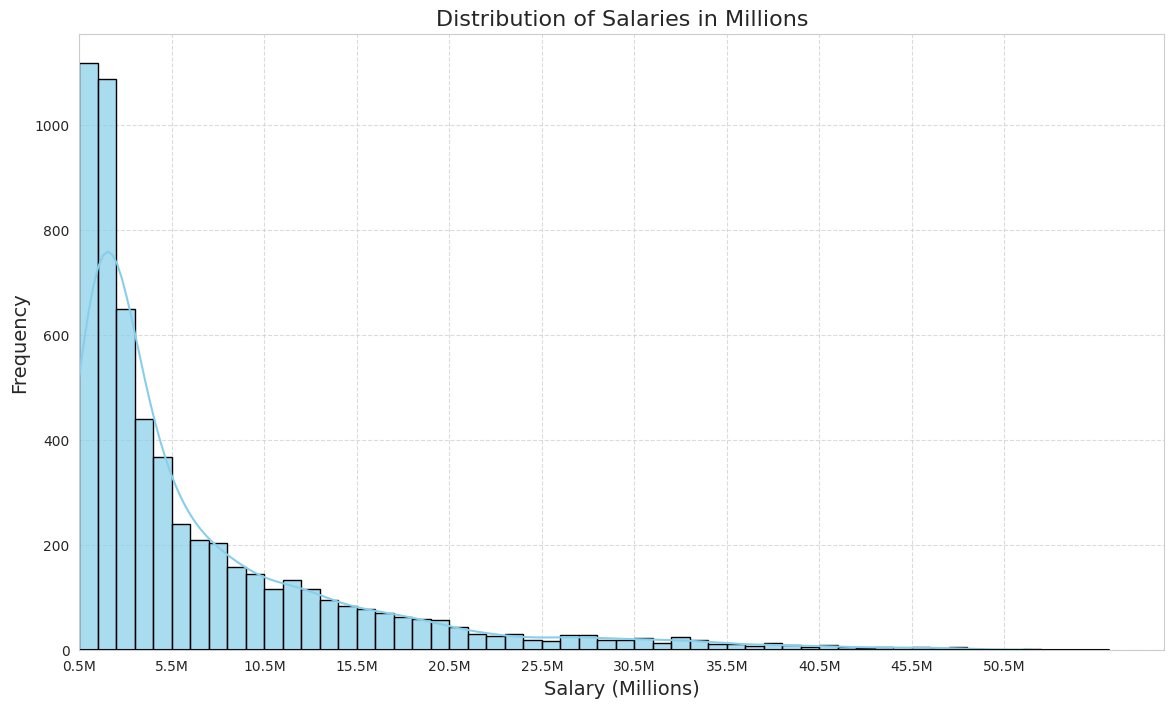

In [ ]:
# @title Distribution

from matplotlib.ticker import FuncFormatter

# Function to format the salary in millions
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

# Assuming your DataFrame is named df_salary and has columns 'SALARY' and 'SEASON_ID'

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the bin edges for the histogram, starting from 500,000
bins = range(500000, int(df_salary['salary'].max()) + 2 * 10**6, 1 * 10**6)  # Adjust the step as needed

# Create a histogram to show the distribution of salaries
plt.figure(figsize=(14, 8))
ax = sns.histplot(df_salary['salary'], bins=bins, kde=True, color="skyblue", alpha=0.7, edgecolor="black")
sns.kdeplot(df_salary['salary'], color="black", ax=ax)
plt.title('Distribution of Salaries in Millions', fontsize=16)
plt.xlabel('Salary (Millions)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
ax.xaxis.set_major_formatter(FuncFormatter(millions))

# Set the x-axis limit to start from 0.5 million
plt.xlim(500000, None)

# Set custom ticks on the x-axis to include 0.5M
ticks = [x for x in range(500000, int(df_salary['salary'].max()) + 2 * 10**6, 5 * 10**6)]
plt.xticks(ticks, [millions(t, None) for t in ticks])

ax.grid(True, linestyle='--', alpha=0.7)
plt.show()

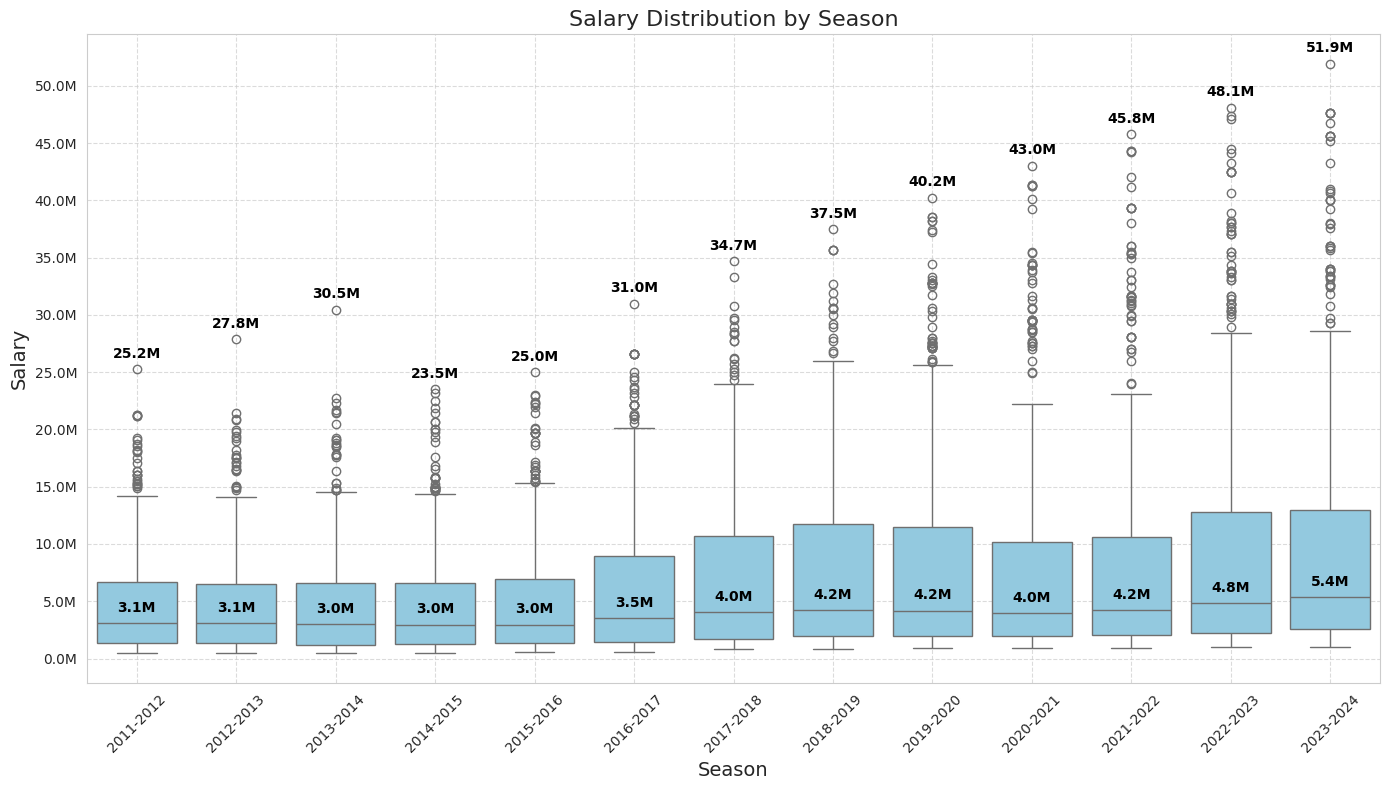

In [ ]:
from matplotlib.ticker import MultipleLocator

# Function to format the salary in millions
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

sns.set_style("whitegrid")

# Create a box plot to show the distribution of salaries across different seasons
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='season', y='salary', data=df_salary, color="skyblue")

plt.title('Salary Distribution by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Salary', fontsize=14)

# Format y-axis labels
ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Set y-axis ticks to change every 5 million
ax.yaxis.set_major_locator(MultipleLocator(5 * 10**6))

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

for season in df_salary['season'].unique():
    season_data = df_salary[df_salary['season'] == season]['salary']
    median = season_data.median()
    max_value = season_data.max()

    # Get the position of the current season
    x_position = list(df_salary['season'].unique()).index(season)

    # Annotate median value and set offset value
    offset = 1 * 10**6
    ax.text(x_position, median + offset, f'{millions(median, None)}',
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='semibold')

    # Annotate max value
    ax.text(x_position, max_value + offset, f'{millions(max_value, None)}',
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='semibold')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



In [ ]:
# @title Outliers

# Function to calculate outliers
def find_outliers(group):
    q1 = group['salary'].quantile(0.25)
    q3 = group['salary'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group['salary'] < lower_bound) | (group['salary'] > upper_bound)]
    outliers_count = len(outliers)
    outliers_avg = (outliers['salary'].mean() / 1e6).round(1)
    outliers_med = (outliers['salary'].median() / 1e6).round(1)
    return pd.Series({'outliers_count': outliers_count, 'outliers_avg': outliers_avg, 'outliers_med': outliers_med})

# Apply the function to each season
outliers_stats = df_salary.groupby('season').apply(find_outliers).reset_index()

# Calculate percent increase and cumulative increase
outliers_stats['percent_increase_outliers'] = outliers_stats['outliers_avg'].pct_change() * 100
outliers_stats['cumulative_increase_outliers'] = ((outliers_stats['outliers_avg'] / outliers_stats['outliers_avg'].iloc[0]) - 1) * 100

# Round the percent increase and cumulative increase to one decimal place
outliers_stats['percent_increase_outliers'] = outliers_stats['percent_increase_outliers'].round(1)
outliers_stats['cumulative_increase_outliers'] = outliers_stats['cumulative_increase_outliers'].round(1)

outliers_stats

,season,outliers_count,outliers_avg,outliers_med,percent_increase_outliers,cumulative_increase_outliers
0,2011-2012,27.0,17.7,17.1,NaN,0.0
1,2012-2013,26.0,18.0,17.5,1.7,1.7
2,2013-2014,25.0,18.8,18.5,4.4,6.2
3,2014-2015,32.0,17.5,15.8,-6.9,-1.1
4,2015-2016,32.0,18.8,18.8,7.4,6.2
5,2016-2017,27.0,23.6,22.9,25.5,33.3
6,2017-2018,18.0,28.1,28.0,19.1,58.8
7,2018-2019,17.0,31.1,30.6,10.7,75.7
8,2019-2020,42.0,30.8,29.4,-1.0,74.0
9,2020-2021,46.0,31.9,30.0,3.6,80.2


In [ ]:
# @title IQR

# Function to calculate IQR statistics
def find_iqr(group):
    q1 = group['salary'].quantile(0.25)
    q3 = group['salary'].quantile(0.75)
    iqr_group = group[(group['salary'] >= q1) & (group['salary'] <= q3)]
    iqr_group_count = len(iqr_group)
    iqr_group_avg = (iqr_group['salary'].mean()/ 1e6).round(1)
    iqr_group_med = (iqr_group['salary'].median()/ 1e6).round(1)

    return pd.Series({'iqr_group_count': iqr_group_count, 'iqr_group_avg': iqr_group_avg, 'iqr_group_med': iqr_group_med})

# Apply the function to each season
iqr_group_stats = df_salary.groupby('season').apply(find_iqr).reset_index()

# Calculate percent increase and cumulative increase
iqr_group_stats['percent_increase_iqr'] = iqr_group_stats['iqr_group_avg'].pct_change() * 100
iqr_group_stats['cumulative_increase_iqr'] = ((iqr_group_stats['iqr_group_avg'] / iqr_group_stats['iqr_group_avg'].iloc[0]) - 1) * 100

# Convert average, percent increase, and cumulative increase to millions
iqr_group_stats['percent_increase_iqr'] = iqr_group_stats['percent_increase_iqr'].round(1)
iqr_group_stats['cumulative_increase_iqr'] = iqr_group_stats['cumulative_increase_iqr'].round(1)

iqr_group_stats


,season,iqr_group_count,iqr_group_avg,iqr_group_med,percent_increase_iqr,cumulative_increase_iqr
0,2011-2012,212.0,3.3,3.0,NaN,0.0
1,2012-2013,222.0,3.2,3.1,-3.0,-3.0
2,2013-2014,223.0,3.1,3.0,-3.1,-6.1
3,2014-2015,234.0,3.1,2.9,0.0,-6.1
4,2015-2016,230.0,3.3,3.0,6.5,0.0
5,2016-2017,240.0,4.0,3.5,21.2,21.2
6,2017-2018,229.0,4.7,4.0,17.5,42.4
7,2018-2019,229.0,5.1,4.2,8.5,54.5
8,2019-2020,210.0,5.0,4.1,-2.0,51.5
9,2020-2021,238.0,4.7,4.0,-6.0,42.4


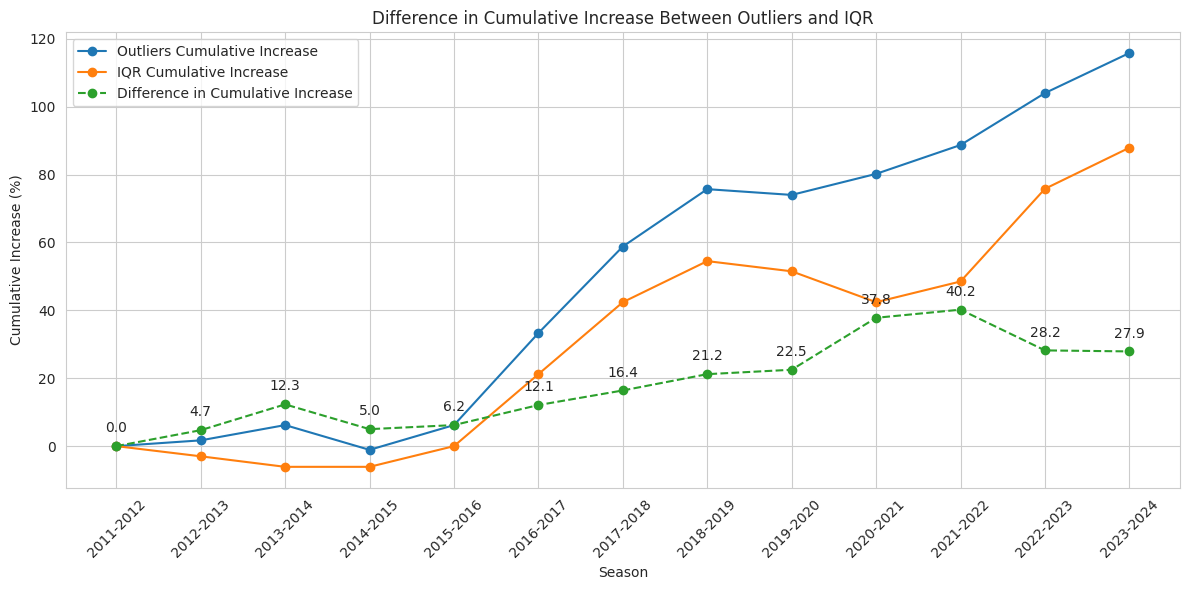

In [ ]:
# @title Outliers and IQR comparison

df_iqr_outliers = pd.merge(iqr_group_stats, outliers_stats, on='season', how='inner')
df_iqr_outliers['cumulative_increase_diff'] =  df_iqr_outliers['cumulative_increase_outliers'] - df_iqr_outliers['cumulative_increase_iqr']

plt.figure(figsize=(12, 6))
plt.plot(df_iqr_outliers['season'], df_iqr_outliers['cumulative_increase_outliers'], marker='o', label='Outliers Cumulative Increase')
plt.plot(df_iqr_outliers['season'], df_iqr_outliers['cumulative_increase_iqr'], marker='o', label='IQR Cumulative Increase')
plt.plot(df_iqr_outliers['season'], df_iqr_outliers['cumulative_increase_diff'], marker='o', linestyle='--', label='Difference in Cumulative Increase')

for i, txt in enumerate(df_iqr_outliers['cumulative_increase_diff']):
    plt.annotate(f'{txt:.1f}', (df_iqr_outliers['season'][i], df_iqr_outliers['cumulative_increase_diff'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Season')
plt.ylabel('Cumulative Increase (%)')
plt.title('Difference in Cumulative Increase Between Outliers and IQR')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# @title Discussion

'''
Overall Distribution:

Each box plot represents the distribution of salaries for a particular season. The boxes show the interquartile range (IQR),
which is the middle 50% of the data. The horizontal line inside each box represents the median salary. The whiskers extend
to the minimum and maximum values within 1.5 times the IQR from the lower and upper quartiles.Individual points beyond the whiskers are outliers.

Median Salaries:

Median salaries are annotated in black inside each box. The median salary has shown a general upward trend over the years.
In the 2011-2012 season, the median salary was around 3.1M and stayed at this level until 2016-2017 season when it increased by 16%.
This coincided with a 35% salary cap increase(the maximum amount teams are allowed to spend without being penalized) before 2016-2017.
When the new CBA(Collective Bargaining Agreement) starting from 2017-2018 season kicked in, the median salary increased to 4.0M and stayed around
this level until 2021-2022 season.
We can see an 18% increase of median in 2022-2023 season, season before new CBA, which is similiar to what happended in 2016-2017 season.
The median salaries have increased cumulatively by 87.9% in this time span

Outliers:

Outliers are represented as individual points beyond the whiskers.
The number of outliers increases significantly in 2019-2020 from 17 to 42, and stayed around that level in the following season
indicating a greater disparity in salaries and that more players earn "star" salaries.
The salaries of outliers have increased significantly over the years - the cumulative increase was 115.8% - which is 27.9 percentage points
more than increase of median salary.

Maximum Salaries:

Maximum salaries are annotated above each box plot in black. The highest recorded salary has steadily increased over the years,
reaching 51.9M in the 2023-2024 season. There was one player in 2011-2014 seasons who earned significantly more thant the rest of the league.

Seasonal Variation:

There is a clear increase in the range of salaries over the seasons.
Earlier seasons (e.g., 2011-2012) have a narrower range compared to later seasons (e.g., 2022-2023).
The gap between median salary and outliers average have steadily widened over the years with a sizeable jump after the 2019-2020 season.
Median salary increases in 2022-2023 and 2023-2024 season reduced the gap and allowed for a return to a more of linear gap increase.

The box plot provides a clear visualization of how player salaries have evolved over the years. Key observations include:

A general upward trend in median salaries.
An increase in the range of salaries, with more high-salary outliers in recent seasons.
The highest salaries have significantly increased, reaching up to 51.9M in the 2023-2024 season.
This analysis highlights the growing disparity in player salaries over the years, with a noticeable increase in both median and maximum salaries.
The increasing number of outliers also suggests that while many players earn within a certain range,
a significant number earn considerably more, particularly in recent seasons.
'''

# Retrieving basic player information


In [ ]:
# Getting unique ids from df_salary
list_of_ids = df_salary['ids'].unique()

# Initialize an empty DataFrame for basic player information
basic_info = pd.DataFrame(columns=['PERSON_ID', 'BIRTHDATE', 'HEIGHT', 'WEIGHT', 'POSITION', 'DRAFT_YEAR', 'DRAFT_NUMBER'])

# Set a counter
count = 0

# Loop to scrape player info for IDs
for id in list_of_ids:
    commoninfofinder = commonplayerinfo.CommonPlayerInfo(player_id=id)
    player = commoninfofinder.get_data_frames()[0]
    basic = player[['PERSON_ID', 'BIRTHDATE', 'HEIGHT', 'WEIGHT', 'POSITION', 'DRAFT_YEAR', 'DRAFT_NUMBER']].copy()
    basic['BIRTHDATE'] = basic['BIRTHDATE'].str.extract(r'(\d{4})')
    count += 1
    basic_info = pd.concat([basic_info, basic], ignore_index=True)
    print(f"Player ID {id} retrieved successfully.")

    # Using sleep function to avoid timing out due to too many API calls
    if count == 20:
        time.sleep(0.601)
        count = 0

# Save to csv file
basic_info.to_csv('df_basic_info_update.csv')

Player ID 977 retrieved successfully.
Player ID 1713 retrieved successfully.
Player ID 708 retrieved successfully.
Player ID 1495 retrieved successfully.
Player ID 1740 retrieved successfully.
Player ID 2240 retrieved successfully.
Player ID 1717 retrieved successfully.
Player ID 2200 retrieved successfully.
Player ID 2546 retrieved successfully.
Player ID 2405 retrieved successfully.
Player ID 2730 retrieved successfully.
Player ID 2207 retrieved successfully.
Player ID 1888 retrieved successfully.
Player ID 1882 retrieved successfully.
Player ID 101114 retrieved successfully.
Player ID 101108 retrieved successfully.
Player ID 200750 retrieved successfully.
Player ID 2544 retrieved successfully.
Player ID 2547 retrieved successfully.
Player ID 2548 retrieved successfully.
Player ID 201142 retrieved successfully.
Player ID 1718 retrieved successfully.
Player ID 1884 retrieved successfully.
Player ID 2216 retrieved successfully.
Player ID 1712 retrieved successfully.
Player ID 200752 re

In [12]:
# @title Data preprocessing

basic_info = pd.read_csv('df_basic_info_update.csv')

basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1253 non-null   int64  
 1   PERSON_ID     0 non-null      float64
 2   BIRTHDATE     1253 non-null   int64  
 3   HEIGHT        1241 non-null   object 
 4   WEIGHT        1241 non-null   float64
 5   POSITION      1241 non-null   object 
 6   DRAFT_YEAR    1253 non-null   object 
 7   DRAFT_NUMBER  1244 non-null   object 
 8   ids           1253 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 88.2+ KB


In [17]:
basic_info.drop(columns=['Unnamed: 0', 'PERSON_ID'], inplace=True)

In [19]:
# Function to convert height in feet to centimeters
def height_in_cm(x):
    if pd.isnull(x) or x == '':
        return None
    split = x.split('-', 1)
    if len(split) == 1:
        try:
            return round((int(split[0]) * 30.48), 0)
        except ValueError:
            return None
    else:
        try:
            return round((int(split[0]) * 30.48 + int(split[1]) * 2.54), 0)
        except ValueError:
            return None

# Apply the function to the 'HEIGHT' column
basic_info['HEIGHT'] = basic_info['HEIGHT'].apply(height_in_cm)

In [20]:
# Function to convert height in feet to centimeters
def weight_in_kg(x):
    if pd.isnull(x) or x == '':
        return None
    else:
        try:
            return round((int(x) * 0.453592), 0)
        except ValueError:
            return None

# Apply the function to the 'HEIGHT' column
basic_info['WEIGHT'] = basic_info['WEIGHT'].apply(weight_in_kg)

In [21]:
basic_info['ids'] = basic_info['ids'].astype(int)

In [8]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1253 non-null   int64  
 1   PERSON_ID     0 non-null      float64
 2   BIRTHDATE     1253 non-null   int64  
 3   HEIGHT        1241 non-null   object 
 4   WEIGHT        1241 non-null   float64
 5   POSITION      1241 non-null   object 
 6   DRAFT_YEAR    1253 non-null   object 
 7   DRAFT_NUMBER  1244 non-null   object 
 8   ids           1253 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 88.2+ KB


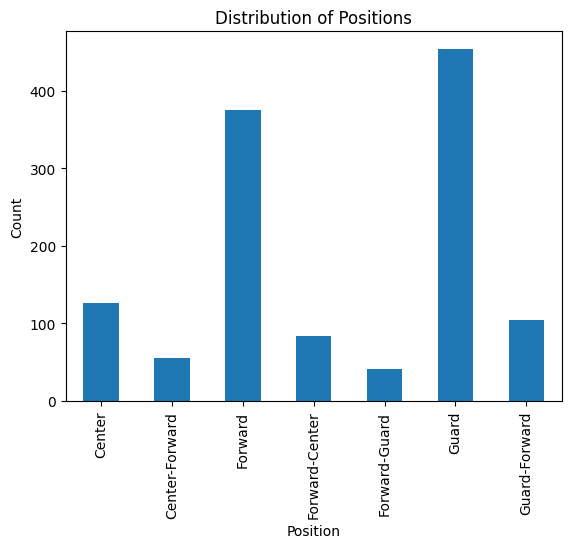

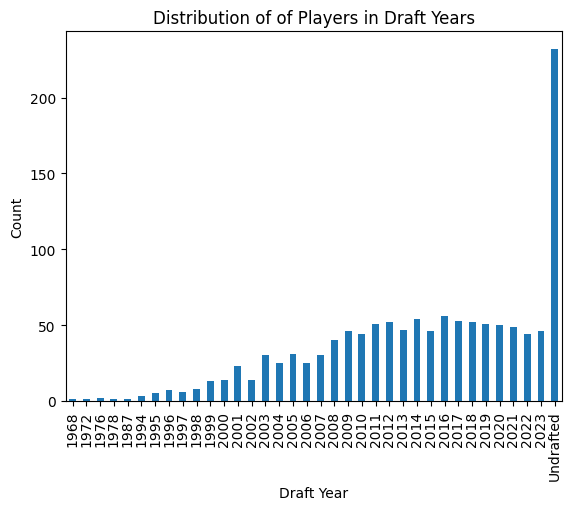

In [22]:
# @title Data visualization

basic_info.groupby('POSITION').size().plot(kind='bar')
plt.title('Distribution of Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

basic_info.groupby('DRAFT_YEAR').size().plot(kind='bar')
plt.title('Distribution of of Players in Draft Years')
plt.xlabel('Draft Year')
plt.ylabel('Count')
plt.show()

In [7]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1253 non-null   int64  
 1   PERSON_ID     0 non-null      float64
 2   BIRTHDATE     1253 non-null   int64  
 3   HEIGHT        1241 non-null   object 
 4   WEIGHT        1241 non-null   float64
 5   POSITION      1241 non-null   object 
 6   DRAFT_YEAR    1253 non-null   object 
 7   DRAFT_NUMBER  1244 non-null   object 
 8   ids           1253 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 88.2+ KB


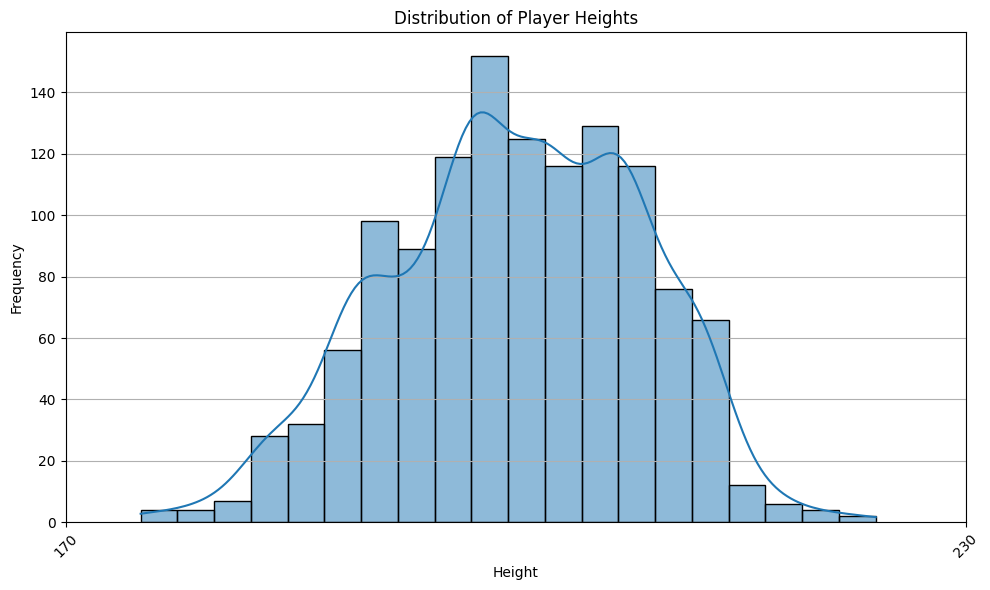

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(basic_info['HEIGHT'], kde=True, bins=20)
plt.title('Distribution of Player Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.xticks(ticks=[170, 230, 5], rotation=45)
plt.xlim(170)
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-85-ac4c15b1dc56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_info_position['POSITION'] = basic_info_position['POSITION'].apply(lambda x: 'Guard' if 'Guard' in x else 'Forward' if 'Forward' in x else 'Center')


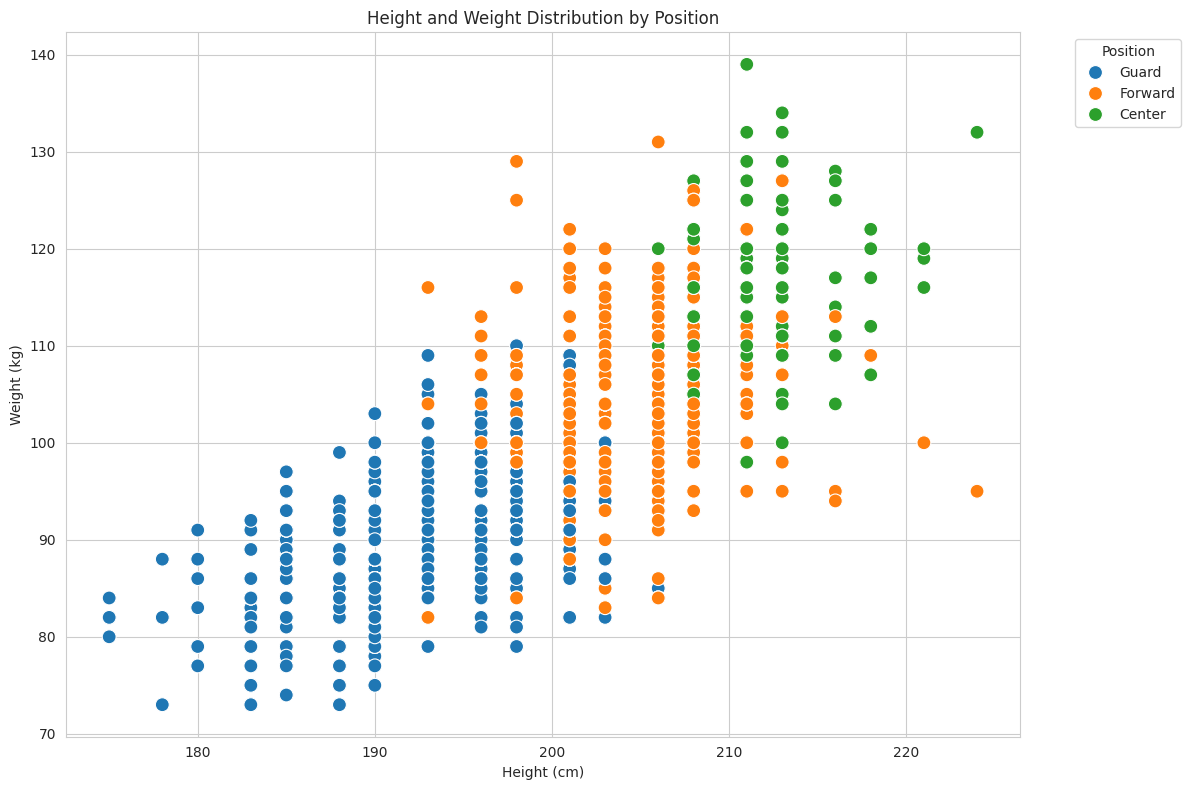

In [ ]:
basic_info_position = basic_info[basic_info['POSITION'].str.contains('Guard|Forward|Center', case=False)]
basic_info_position['POSITION'] = basic_info_position['POSITION'].apply(lambda x: 'Guard' if 'Guard' in x else 'Forward' if 'Forward' in x else 'Center')

plt.figure(figsize=(12, 8))
sns.scatterplot(data=basic_info_position,
                x='HEIGHT', y='WEIGHT', hue='POSITION', palette='tab10', s=100)
plt.title('Height and Weight Distribution by Position')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
basic_info = pd.read_csv('df_basic_info_update.csv')

In [ ]:
# @title Dataframe merge

# Create deep copy of dataframes
basic = basic_info.copy(deep=True)
df = df_salary.copy(deep=True)

# Merge df_salary (df) with basic_info (basic) on the 'ids' column, using an inner join
# This ensures that only records with matching 'ids' in both DataFrames are included in the result
result_df = df.merge(basic, on='ids', how='inner')

result_df

,name,salary,adjusted_salary,season,ids,Unnamed: 0,PERSON_ID,BIRTHDATE,HEIGHT,WEIGHT,POSITION,DRAFT_YEAR,DRAFT_NUMBER
0,Kobe Bryant,25244493,34123045,2011-2012,977,0,NaN,1978,6-6,212.0,Forward-Guard,1996,13
1,Kobe Bryant,27849000,37027429,2012-2013,977,0,NaN,1978,6-6,212.0,Forward-Guard,1996,13
2,Kobe Bryant,30453000,39791542,2013-2014,977,0,NaN,1978,6-6,212.0,Forward-Guard,1996,13
3,Kobe Bryant,23500000,30082953,2014-2015,977,0,NaN,1978,6-6,212.0,Forward-Guard,1996,13
4,Kobe Bryant,25000000,31963580,2015-2016,977,0,NaN,1978,6-6,212.0,Forward-Guard,1996,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5923,Kendall Brown,1100000,1100000,2023-2024,1631112,1248,NaN,2003,6-7,205.0,Guard,2022,48
5924,Stanley Umude,1098242,1098242,2023-2024,1630649,1249,NaN,1999,6-6,210.0,Guard,Undrafted,Undrafted
5925,Gui Santos,1029483,1029483,2023-2024,1630611,1250,NaN,2002,6-6,185.0,Forward,2022,55
5926,Dominick Barlow,1015402,1015402,2023-2024,1631230,1251,NaN,2003,6-9,215.0,Forward,Undrafted,Undrafted


In [ ]:
result_df.drop(columns=['PERSON_ID', 'Unnamed: 0'], inplace=True)
result_df

,name,salary,adjusted_salary,season,ids,BIRTHDATE,HEIGHT,WEIGHT,POSITION,DRAFT_YEAR,DRAFT_NUMBER
0,Kobe Bryant,25244493,34123045,2011-2012,977,1978,6-6,212.0,Forward-Guard,1996,13
1,Kobe Bryant,27849000,37027429,2012-2013,977,1978,6-6,212.0,Forward-Guard,1996,13
2,Kobe Bryant,30453000,39791542,2013-2014,977,1978,6-6,212.0,Forward-Guard,1996,13
3,Kobe Bryant,23500000,30082953,2014-2015,977,1978,6-6,212.0,Forward-Guard,1996,13
4,Kobe Bryant,25000000,31963580,2015-2016,977,1978,6-6,212.0,Forward-Guard,1996,13
...,...,...,...,...,...,...,...,...,...,...,...
5923,Kendall Brown,1100000,1100000,2023-2024,1631112,2003,6-7,205.0,Guard,2022,48
5924,Stanley Umude,1098242,1098242,2023-2024,1630649,1999,6-6,210.0,Guard,Undrafted,Undrafted
5925,Gui Santos,1029483,1029483,2023-2024,1630611,2002,6-6,185.0,Forward,2022,55
5926,Dominick Barlow,1015402,1015402,2023-2024,1631230,2003,6-9,215.0,Forward,Undrafted,Undrafted


In [ ]:
# Changing season format so I can join df_salary_basic_2011_current with player stats, eg. 2011-2012 will be 2011-12.
result_df['season'] = result_df['season'].str.replace(r'(\d{4})-(\d{2})(\d{2})', r'\1-\3', regex=True)

# Changing column names
result_df['PLAYER_ID'] = result_df['ids']
result_df.drop(columns='ids', inplace=True)
result_df['SEASON_ID'] = result_df['season']
result_df.drop(columns='season', inplace=True)
result_df['SALARY'] = result_df['salary']
result_df.drop(columns='salary', inplace=True)
result_df['ADJUSTED_SALARY'] = result_df['adjusted_salary']
result_df.drop(columns='adjusted_salary', inplace=True)
result_df['NAME'] = result_df['name']
result_df.drop(columns='name', inplace=True)
result_df

,BIRTHDATE,HEIGHT,WEIGHT,POSITION,DRAFT_YEAR,DRAFT_NUMBER,PLAYER_ID,SEASON_ID,SALARY,ADJUSTED_SALARY,NAME
0,1978,6-6,212.0,Forward-Guard,1996,13,977,2011-12,25244493,34123045,Kobe Bryant
1,1978,6-6,212.0,Forward-Guard,1996,13,977,2012-13,27849000,37027429,Kobe Bryant
2,1978,6-6,212.0,Forward-Guard,1996,13,977,2013-14,30453000,39791542,Kobe Bryant
3,1978,6-6,212.0,Forward-Guard,1996,13,977,2014-15,23500000,30082953,Kobe Bryant
4,1978,6-6,212.0,Forward-Guard,1996,13,977,2015-16,25000000,31963580,Kobe Bryant
...,...,...,...,...,...,...,...,...,...,...,...
5923,2003,6-7,205.0,Guard,2022,48,1631112,2023-24,1100000,1100000,Kendall Brown
5924,1999,6-6,210.0,Guard,Undrafted,Undrafted,1630649,2023-24,1098242,1098242,Stanley Umude
5925,2002,6-6,185.0,Forward,2022,55,1630611,2023-24,1029483,1029483,Gui Santos
5926,2003,6-9,215.0,Forward,Undrafted,Undrafted,1631230,2023-24,1015402,1015402,Dominick Barlow


In [ ]:
# Saving resulting to df to a csv file
result_df.to_csv('df_salary_basic_2011_current_update.csv')

# Retrieving player stats


In [ ]:
# Initialize an empty DataFrame for stats
stats = pd.DataFrame()

# Get unique player IDs from the original DataFrame
df_ids = result_df['PLAYER_ID'].unique()

# Loop through each player ID
for player_id in df_ids:
    try:
        # Retrieve player career stats
        pcs = playercareerstats.PlayerCareerStats(player_id=player_id)

        # Get the first DataFrame from the returned list
        player = pcs.get_data_frames()[0]

        # Get the seasons for the current player from the original DataFrame
        seasons = result_df[result_df['PLAYER_ID'] == player_id]['SEASON_ID'].values

        # Filter the player's career stats for the relevant seasons
        filtered_player = player[player['SEASON_ID'].isin(seasons)]

        # Concatenate the filtered stats to the overall stats DataFrame
        stats = pd.concat([stats, filtered_player], ignore_index=True)
        print(f"Player ID {player_id} retrieved successfully.")

    except Exception as e:
        print(f"An error occurred for player ID {player_id}: {e}")


Player ID 977 retrieved successfully.
Player ID 1713 retrieved successfully.
Player ID 708 retrieved successfully.
Player ID 1495 retrieved successfully.
Player ID 1740 retrieved successfully.
Player ID 2240 retrieved successfully.
Player ID 1717 retrieved successfully.
Player ID 2200 retrieved successfully.
Player ID 2546 retrieved successfully.
Player ID 2405 retrieved successfully.
Player ID 2730 retrieved successfully.
Player ID 2207 retrieved successfully.
Player ID 1888 retrieved successfully.
Player ID 1882 retrieved successfully.
Player ID 101114 retrieved successfully.
Player ID 101108 retrieved successfully.
Player ID 200750 retrieved successfully.
Player ID 2544 retrieved successfully.
Player ID 2547 retrieved successfully.
Player ID 2548 retrieved successfully.
Player ID 201142 retrieved successfully.
Player ID 1718 retrieved successfully.
Player ID 1884 retrieved successfully.
Player ID 2216 retrieved successfully.
Player ID 1712 retrieved successfully.
Player ID 200752 re

In [ ]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7130 entries, 0 to 7129
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          7130 non-null   int64  
 1   SEASON_ID          7130 non-null   object 
 2   TEAM_ID            7130 non-null   int64  
 3   TEAM_ABBREVIATION  7130 non-null   object 
 4   PLAYER_AGE         7130 non-null   float64
 5   GP                 7130 non-null   int64  
 6   GS                 7130 non-null   float64
 7   MIN                7130 non-null   float64
 8   FGM                7130 non-null   int64  
 9   FGA                7130 non-null   int64  
 10  FG_PCT             7130 non-null   float64
 11  FG3M               7130 non-null   float64
 12  FG3A               7130 non-null   float64
 13  FG3_PCT            7130 non-null   float64
 14  FTM                7130 non-null   int64  
 15  FTA                7130 non-null   int64  
 16  FT_PCT             7130 

In [ ]:
# Save stats df to a csv file
stats.to_csv('df_stats_2011_current_update.csv')

In [ ]:
stats = pd.read_csv('df_stats_2011_current_update.csv')

In [ ]:
# @title Dataframe prep

stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7130 entries, 0 to 7129
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         7130 non-null   int64  
 1   PLAYER_ID          7130 non-null   int64  
 2   SEASON_ID          7130 non-null   object 
 3   LEAGUE_ID          7130 non-null   int64  
 4   TEAM_ID            7130 non-null   int64  
 5   TEAM_ABBREVIATION  7130 non-null   object 
 6   PLAYER_AGE         7130 non-null   float64
 7   GP                 7130 non-null   int64  
 8   GS                 7130 non-null   float64
 9   MIN                7130 non-null   float64
 10  FGM                7130 non-null   int64  
 11  FGA                7130 non-null   int64  
 12  FG_PCT             7130 non-null   float64
 13  FG3M               7130 non-null   float64
 14  FG3A               7130 non-null   float64
 15  FG3_PCT            7130 non-null   float64
 16  FTM                7130 

In [ ]:
# Converting object values to int
stats[['GP', 'FGM', 'FGA', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']] = stats[['GP', 'FGM', 'FGA', 'FTM', 'FTA', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']].astype(int)

In [ ]:
# Dropping unnecessary columns
stats.drop(columns=['Unnamed: 0', 'LEAGUE_ID'], inplace=True)
stats

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,977,2011-12,1610612747,LAL,33.0,58,58.0,2232.0,574,1336,...,0.845,66.0,247.0,313,264,69,18,204,105,1616
1,977,2012-13,1610612747,LAL,34.0,78,78.0,3013.0,738,1595,...,0.839,66.0,367.0,433,469,106,25,287,173,2133
2,977,2013-14,1610612747,LAL,35.0,6,6.0,177.0,31,73,...,0.857,2.0,24.0,26,38,7,1,34,9,83
3,977,2014-15,1610612747,LAL,36.0,35,35.0,1207.0,266,713,...,0.813,26.0,173.0,199,197,47,7,128,65,782
4,977,2015-16,1610612747,LAL,37.0,66,66.0,1863.0,398,1113,...,0.826,41.0,206.0,247,184,62,13,129,115,1161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125,1631112,2023-24,1610612754,IND,21.0,15,0.0,63.0,8,15,...,0.625,3.0,2.0,5,5,0,0,2,9,21
7126,1630649,2023-24,1610612765,DET,25.0,24,2.0,307.0,37,84,...,0.906,8.0,43.0,51,11,8,7,14,40,127
7127,1630611,2023-24,1610612744,GSW,22.0,23,0.0,192.0,28,55,...,0.941,17.0,32.0,49,14,4,2,7,23,82
7128,1631230,2023-24,1610612759,SAS,21.0,33,1.0,420.0,56,113,...,0.690,45.0,68.0,113,36,12,14,9,47,144


In [ ]:
stats.columns

Index(['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PLAYER_AGE',
       'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'],
      dtype='object')

In [ ]:
# Changing column names
stats.rename(columns={'TEAM_ABBREVIATION': 'TEAM', 'PLAYER_AGE': 'AGE'}, inplace=True)

In [ ]:
stats[stats['TEAM'] == 'TOT'][['PLAYER_ID', 'SEASON_ID', 'PTS']]

,PLAYER_ID,SEASON_ID,PTS
19,708,2014-15,323
47,2200,2018-19,118
64,2405,2014-15,680
83,2207,2015-16,992
87,2207,2017-18,372
...,...,...,...
7045,1631157,2023-24,44
7054,1630647,2022-23,278
7059,1630688,2023-24,23
7067,203995,2023-24,422


In [ ]:
pid_sid = []

tot_df = stats[stats['TEAM'] == 'TOT']
for i, row in tot_df.iterrows():
    player_id = row['PLAYER_ID']
    season_id = row['SEASON_ID']
    pid_sid.append((player_id, season_id))

In [ ]:
len(pid_sid)

719

In [ ]:
match_df = pd.DataFrame(pid_sid, columns=['PLAYER_ID', 'SEASON_ID'])

pid_sid_df = pd.merge(match_df, stats, on=['PLAYER_ID', 'SEASON_ID'], how='left')
pid_sid_df.head(50)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM,AGE,GP,GS,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,708,2014-15,1610612751,BKN,39.0,42,42.0,854.0,125,275,...,0.829,46.0,239.0,285,69,41,13,45,96,285
1,708,2014-15,1610612750,MIN,39.0,5,5.0,98.0,18,31,...,0.500,2.0,24.0,26,8,5,4,1,13,38
2,708,2014-15,0,TOT,39.0,47,47.0,952.0,143,306,...,0.800,48.0,263.0,311,77,46,17,46,109,323
3,2200,2018-19,1610612759,SAS,38.0,27,6.0,330.0,41,88,...,0.711,22.0,105.0,127,50,5,14,14,28,114
4,2200,2018-19,1610612749,MIL,38.0,3,0.0,30.0,1,6,...,0.500,0.0,10.0,10,2,0,1,2,1,4
5,2200,2018-19,0,TOT,38.0,30,6.0,361.0,42,94,...,0.700,22.0,115.0,137,52,5,15,16,29,118
6,2405,2014-15,1610612752,NYK,32.0,36,14.0,865.0,169,311,...,0.740,83.0,162.0,245,37,20,34,63,111,432
7,2405,2014-15,1610612742,DAL,32.0,23,1.0,380.0,104,179,...,0.678,27.0,57.0,84,8,9,4,15,50,248
8,2405,2014-15,0,TOT,32.0,59,15.0,1244.0,273,490,...,0.720,110.0,219.0,329,45,29,38,78,161,680
9,2207,2015-16,1610612751,BKN,35.0,57,57.0,1934.0,247,608,...,0.852,34.0,190.0,224,232,40,2,116,100,671


In [ ]:
stats['MIN_PER_GAME'] = round(stats['MIN'] / stats['GP'], 1)
stats['PTS_PER_GAME'] = round(stats['PTS'] / stats['GP'], 1)
stats['AST_PER_GAME'] = round(stats['AST'] / stats['GP'], 1)
stats['STL_PER_GAME'] = round(stats['STL'] / stats['GP'], 1)
stats['BLK_PER_GAME'] = round(stats['BLK'] / stats['GP'], 1)
stats['TOV_PER_GAME'] = round(stats['TOV'] / stats['GP'], 1)